In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This notebook implements a speech quality scoring system using audio processing and machine learning. The key steps:

* Audio Processing: Uses Whisper-small model to extract 768-dimensional features from audio files
* Data Preparation: Converts ratings (1.0-5.0 in 0.5 increments) to 9 classes
* Model Training: Trains multiple models (XGBoost, CatBoost, Random Forest, KNN, MLP) for both classification and regression
* Ensemble Creation: Builds a weighted ensemble using optimal blending of model predictions
* Inference: Makes predictions on test data and saves multiple submission files
* Performance: Best model achieves ~96% accuracy on validation data.

In [2]:
df=pd.read_csv('/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv')
df['label'].value_counts()

label
3.0    154
2.0     90
2.5     72
3.5     46
5.0     20
4.0     15
4.5     10
1.0      1
1.5      1
Name: count, dtype: int64

In [3]:
import librosa
audio_file_path='/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_40.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [4]:
print(librosa_audio_data)

[ 2.8933557e-05  2.7449032e-05  1.0477873e-05 ... -2.1593846e-04
  1.3209385e-05  8.0031226e-05]


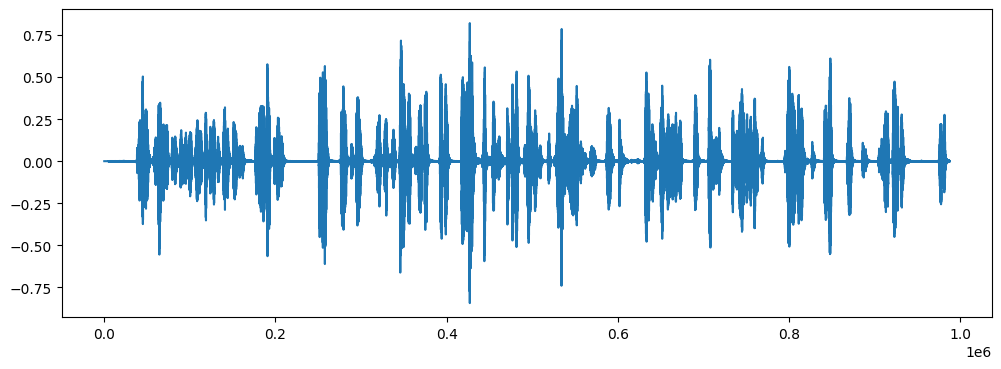

In [5]:
### Lets plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [6]:
#!pip install resampy
from tqdm import tqdm

### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath('/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train'),str(row["filename"])+'.wav')
    final_class_labels=row["label"]
    
    extracted_features.append([file_name, final_class_labels])

409it [00:00, 19836.84it/s]


In [7]:
### converting extracted_features to Pandas dataframe
df=pd.DataFrame(extracted_features,columns=['audio_path','score'])
df.head()

,audio_path,score
0,/kaggle/input/shl-intern-hiring-assessment-202...,3.0
1,/kaggle/input/shl-intern-hiring-assessment-202...,3.0
2,/kaggle/input/shl-intern-hiring-assessment-202...,2.0
3,/kaggle/input/shl-intern-hiring-assessment-202...,2.0
4,/kaggle/input/shl-intern-hiring-assessment-202...,3.5


In [8]:
score_to_class = {s: i for i, s in enumerate([1.0 + 0.5*i for i in range(9)])}

df['label_class'] = df['score'].map(score_to_class)
from sklearn.utils import resample

df_list = []
for label in df['label_class'].unique():
    df_label = df[df['label_class'] == label]
    df_label_upsampled = resample(df_label,
                                   replace=True,
                                   n_samples=df['label_class'].value_counts().max(),
                                   random_state=42)
    df_list.append(df_label_upsampled)

df_balanced = pd.concat(df_list).sample(frac=1, random_state=42).reset_index(drop=True)
df

,audio_path,score,label_class
0,/kaggle/input/shl-intern-hiring-assessment-202...,3.0,4
1,/kaggle/input/shl-intern-hiring-assessment-202...,3.0,4
2,/kaggle/input/shl-intern-hiring-assessment-202...,2.0,2
3,/kaggle/input/shl-intern-hiring-assessment-202...,2.0,2
4,/kaggle/input/shl-intern-hiring-assessment-202...,3.5,5
...,...,...,...
404,/kaggle/input/shl-intern-hiring-assessment-202...,3.0,4
405,/kaggle/input/shl-intern-hiring-assessment-202...,3.5,5
406,/kaggle/input/shl-intern-hiring-assessment-202...,3.0,4
407,/kaggle/input/shl-intern-hiring-assessment-202...,2.5,3


In [9]:
a=df_balanced.audio_path.iloc[0]
librosa_audio_data,librosa_sample_rate=librosa.load(a)
librosa_audio_data

array([ 2.8933557e-05,  2.7449032e-05,  1.0477873e-05, ...,
       -2.1593846e-04,  1.3209385e-05,  8.0031226e-05], dtype=float32)

### custom dataset preparation 

In [10]:
import numpy as np
import pandas as pd
import torch
import torchaudio as ta
from transformers import WhisperProcessor, WhisperModel
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from tqdm import tqdm
import os

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pre-trained Whisper processor and model (FIXED)
print("Loading Whisper model...")
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperModel.from_pretrained("openai/whisper-small").to(device)
whisper_model.eval()  # Set to evaluation mode

def extract_whisper_features(audio_path, max_duration=30):
    """
    Extract features using Whisper small model
    Returns: 768-dimensional feature vector (encoder output)
    """
    try:
        # Load audio
        waveform, sample_rate = ta.load(audio_path)
        
        # Resample to 16kHz (Whisper requirement)
        if sample_rate != 16000:
            resampler = ta.transforms.Resample(sample_rate, 16000)
            waveform = resampler(waveform)
        
        # Take first 30 seconds if longer
        max_samples = 16000 * max_duration
        if waveform.shape[1] > max_samples:
            waveform = waveform[:, :max_samples]
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Prepare for Whisper
        audio_array = waveform.squeeze().numpy()
        
        # Extract features
        input_features = processor(
            audio_array, 
            sampling_rate=16000, 
            return_tensors="pt"
        ).input_features.to(device)
        
        # Extract encoder features only (no decoder needed)
        with torch.no_grad():
            # Pass through encoder
            encoder_outputs = whisper_model.encoder(input_features)
            # Get last hidden state
            last_hidden_state = encoder_outputs.last_hidden_state  # [1, time, 768]
            # Mean pool across time dimension
            features = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        
        return features
    
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        # Return zeros with correct dimension
        return np.zeros(768)  # Whisper-small encoder output dimension is 768

def preprocess_all_audio(df, max_files=None):
    """
    Extract Whisper features for all audio files
    """
    X_features = []
    y_labels = []
    audio_paths = []
    
    print(f"Extracting features for {len(df)} audio files...")
    
    # Limit files for testing if needed
    if max_files:
        df = df.head(max_files)
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        audio_path = row['audio_path']
        label = row['label_class']
        
        # Extract Whisper features
        features = extract_whisper_features(audio_path)
        
        X_features.append(features)
        y_labels.append(label)
        audio_paths.append(audio_path)
    
    return np.array(X_features), np.array(y_labels), audio_paths

# Extract features (test with smaller batch first)
print("Testing with first 10 files...")
X_test, y_test, paths_test = preprocess_all_audio(df_balanced.head(10))
print(f"Test feature shape: {X_test.shape}, Feature dimension: {X_test.shape[1]}")

# If successful, process all
if X_test.shape[0] > 0 and X_test.shape[1] > 0:
    print("\nProcessing all files...")
    X, y, paths = preprocess_all_audio(df_balanced)
    print(f"Final feature shape: {X.shape}, Labels shape: {y.shape}")
else:
    print("Whisper extraction failed. Trying Wav2Vec2...")

2025-12-17 23:19:20.438211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766013560.658828      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766013560.723786      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading Whisper model...


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Testing with first 10 files...
Extracting features for 10 audio files...


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Test feature shape: (10, 768), Feature dimension: 768

Processing all files...
Extracting features for 1386 audio files...


100%|██████████| 1386/1386 [04:38<00:00,  4.97it/s]

Final feature shape: (1386, 768), Labels shape: (1386,)


In [13]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# Option A: XGBoost for Classification (9 classes)
print("\n=== Training XGBoost Classifier ===")
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist'
)

xgb_clf.fit(X_train, y_train)

# Predict
y_pred_clf = xgb_clf.predict(X_val)
y_pred_proba = xgb_clf.predict_proba(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_clf)
print(f"XGBoost Classification Accuracy: {accuracy:.4f}")

# Option B: XGBoost for Regression (predict actual scores)
print("\n=== Training XGBoost Regressor ===")
# Convert back to actual scores
score_mapping = {i: 1.0 + 0.5*i for i in range(9)}
y_train_scores = np.array([score_mapping[label] for label in y_train])
y_val_scores = np.array([score_mapping[label] for label in y_val])

xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist'
)

xgb_reg.fit(X_train, y_train_scores)

# Predict
y_pred_scores = xgb_reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val_scores, y_pred_scores))
print(f"XGBoost Regression RMSE: {rmse:.4f}")

# Round to nearest 0.5 for classification
y_pred_rounded = np.round(y_pred_scores * 2) / 2
accuracy_reg = np.mean(y_pred_rounded == y_val_scores)
print(f"Rounded Regression Accuracy: {accuracy_reg:.4f}")

Train: (1108, 768), Val: (278, 768)

=== Training XGBoost Classifier ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:33:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

XGBoost Classification Accuracy: 0.9460

=== Training XGBoost Regressor ===
XGBoost Regression RMSE: 0.1565
Rounded Regression Accuracy: 0.9604


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:33:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [15]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tqdm.auto import tqdm
import os

print("="*60)
print("SIMPLIFIED ENSEMBLE TRAINING")
print("="*60)

# ==============================================
# 1. DATA PREPARATION
# ==============================================

print("\n📊 Data Preparation")
print("-"*40)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# For regression
score_mapping = {i: 1.0 + 0.5*i for i in range(9)}
y_train_scores = np.array([score_mapping[label] for label in y_train])
y_val_scores = np.array([score_mapping[label] for label in y_val])

# ==============================================
# 2. TRAIN MODELS
# ==============================================

print("\n🤖 Training Models")
print("-"*40)

models = {}
results = {}

# 1. XGBoost Classifier
print("1. XGBoost Classifier...")
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist'
)
xgb_clf.fit(X_train_scaled, y_train)
y_pred = xgb_clf.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
models['xgb_clf'] = xgb_clf
results['xgb_clf'] = acc
print(f"   Accuracy: {acc:.4f}")

# 2. XGBoost Regressor
print("2. XGBoost Regressor...")
xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist'
)
xgb_reg.fit(X_train_scaled, y_train_scores)
y_pred = xgb_reg.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val_scores, y_pred))
y_pred_rounded = np.round(y_pred * 2) / 2
acc = np.mean(y_pred_rounded == y_val_scores)
models['xgb_reg'] = xgb_reg
results['xgb_reg'] = acc
print(f"   Accuracy: {acc:.4f}, RMSE: {rmse:.4f}")

# 3. CatBoost Classifier
print("3. CatBoost Classifier...")
cb_clf = cb.CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.05,
    random_seed=42,
    verbose=0,
    task_type='GPU' if torch.cuda.is_available() else 'CPU'
)
cb_clf.fit(X_train_scaled, y_train)
y_pred = cb_clf.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
models['cb_clf'] = cb_clf
results['cb_clf'] = acc
print(f"   Accuracy: {acc:.4f}")

# 4. Random Forest Classifier
print("4. Random Forest Classifier...")
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_scaled, y_train)
y_pred = rf_clf.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
models['rf_clf'] = rf_clf
results['rf_clf'] = acc
print(f"   Accuracy: {acc:.4f}")

# 5. Random Forest Regressor
print("5. Random Forest Regressor...")
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train_scaled, y_train_scores)
y_pred = rf_reg.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val_scores, y_pred))
y_pred_rounded = np.round(y_pred * 2) / 2
acc = np.mean(y_pred_rounded == y_val_scores)
models['rf_reg'] = rf_reg
results['rf_reg'] = acc
print(f"   Accuracy: {acc:.4f}, RMSE: {rmse:.4f}")

# 6. KNN
print("6. K-Nearest Neighbors...")
knn = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    n_jobs=-1
)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
models['knn'] = knn
results['knn'] = acc
print(f"   Accuracy: {acc:.4f}")

# 7. MLP (Neural Network)
print("7. Neural Network (MLP)...")
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    max_iter=300,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
models['mlp'] = mlp
results['mlp'] = acc
print(f"   Accuracy: {acc:.4f}")

# ==============================================
# 3. WEIGHTED ENSEMBLE
# ==============================================

print("\n⚖️  Creating Weighted Ensemble")
print("-"*40)

# Get probability predictions from base classifiers
base_models = ['xgb_clf', 'cb_clf', 'rf_clf', 'knn', 'mlp']
predictions_val = {}

for name in base_models:
    if name in models:
        try:
            pred_proba = models[name].predict_proba(X_val_scaled)
            predictions_val[name] = pred_proba
        except:
            continue

if predictions_val:
    # Find optimal weights
    n_models = len(predictions_val)
    model_names = list(predictions_val.keys())
    
    print(f"Finding optimal weights for {n_models} models...")
    
    best_weights = None
    best_acc = 0
    
    for _ in range(200):  # 200 random weight combinations
        # Random weights
        weights = np.random.dirichlet(np.ones(n_models))
        weights = weights / weights.sum()
        
        # Weighted average
        weighted_proba = sum(w * predictions_val[name] 
                            for w, name in zip(weights, model_names))
        weighted_pred = np.argmax(weighted_proba, axis=1)
        acc = accuracy_score(y_val, weighted_pred)
        
        if acc > best_acc:
            best_acc = acc
            best_weights = dict(zip(model_names, weights))
    
    print(f"Best ensemble accuracy: {best_acc:.4f}")
    print("Optimal weights:")
    for model_name, weight in best_weights.items():
        print(f"  {model_name}: {weight:.3f}")
    
    # Create weighted ensemble function
    class WeightedEnsemble:
        def __init__(self, models, weights):
            self.models = models
            self.weights = weights
        
        def predict(self, X):
            proba_sum = None
            for name, model in self.models.items():
                if name in self.weights:
                    proba = model.predict_proba(X)
                    if proba_sum is None:
                        proba_sum = proba * self.weights[name]
                    else:
                        proba_sum += proba * self.weights[name]
            return np.argmax(proba_sum, axis=1)
    
    # Only include models with weights
    ensemble_models = {name: models[name] for name in best_weights.keys()}
    weighted_ensemble = WeightedEnsemble(ensemble_models, best_weights)
    models['weighted_ensemble'] = weighted_ensemble
    results['weighted_ensemble'] = best_acc
else:
    print("Could not create weighted ensemble")

# ==============================================
# 4. RESULTS
# ==============================================

print("\n" + "="*60)
print("RESULTS")
print("="*60)

# Sort results
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\nModel Performance (Accuracy):")
for name, acc in sorted_results:
    print(f"  {name:20s}: {acc:.4f}")

best_model_name, best_acc = sorted_results[0]
print(f"\n🏆 Best Model: {best_model_name} (Accuracy: {best_acc:.4f})")

# ==============================================
# 5. PREDICT ON TEST SET
# ==============================================

print("\n🔮 Making Test Predictions")
print("-"*40)

# Prepare test data
test_df = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv")
test_paths = []

for _, row in test_df.iterrows():
    file_path = os.path.join(
        '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test',
        row["filename"] + '.wav'
    )
    test_paths.append(file_path)

test_df = pd.DataFrame({'audio_path': test_paths})

# Extract test features
print("Extracting test features...")
X_test = []
for audio_path in tqdm(test_df['audio_path'], desc="Processing"):
    features = extract_whisper_features(audio_path)
    X_test.append(features)
X_test = np.array(X_test)

# Scale features
X_test_scaled = scaler.transform(X_test)

# Make predictions with all models
all_predictions = {}
print("\nMaking predictions...")

for name, model in models.items():
    print(f"  {name}...")
    try:
        if name == 'weighted_ensemble':
            pred_classes = model.predict(X_test_scaled)
            pred_scores = np.array([1.0 + 0.5 * c for c in pred_classes])
        elif 'reg' in name:  # Regressor
            pred_scores = model.predict(X_test_scaled)
            pred_scores = np.round(pred_scores * 2) / 2  # Round to 0.5
        else:  # Classifier
            pred_classes = model.predict(X_test_scaled)
            pred_scores = np.array([1.0 + 0.5 * c for c in pred_classes])
        
        # Clip to valid range
        pred_scores = np.clip(pred_scores, 1.0, 5.0)
        pred_scores = np.round(pred_scores * 2) / 2  # Ensure 0.5 increments
        
        all_predictions[name] = pred_scores
    except Exception as e:
        print(f"    Error: {e}")

# Create ensemble (average of top 3 models)
print("\nCreating ensemble predictions...")
top_models = [name for name, _ in sorted_results[:3]]
print(f"Top models: {top_models}")

ensemble_scores = np.zeros(len(X_test))
count = 0

for name in top_models:
    if name in all_predictions:
        ensemble_scores += all_predictions[name]
        count += 1

if count > 0:
    ensemble_scores /= count
    ensemble_scores = np.round(ensemble_scores * 2) / 2
    ensemble_scores = np.clip(ensemble_scores, 1.0, 5.0)
else:
    ensemble_scores = np.ones(len(X_test)) * 3.0  # Default

all_predictions['ensemble'] = ensemble_scores

# ==============================================
# 6. SAVE PREDICTIONS
# ==============================================

print("\n💾 Saving Predictions")
print("-"*40)

# Get filenames
test_df['filename'] = test_df['audio_path'].apply(lambda x: os.path.basename(x).replace('.wav', ''))

# Save all predictions
for name, scores in all_predictions.items():
    # Ensure 1D array
    if scores.ndim > 1:
        scores = scores.flatten()
    
    # Create submission
    submission = pd.DataFrame({
        'filename': test_df['filename'],
        'label': scores
    })
    
    # Save
    filename = f'submission_{name}.csv'
    submission.to_csv(filename, index=False)
    print(f"✅ {filename}")

# Save best model
best_scores = all_predictions.get(best_model_name, ensemble_scores)
if best_scores.ndim > 1:
    best_scores = best_scores.flatten()

best_submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': best_scores
})
best_submission.to_csv('submission_best.csv', index=False)
print(f"✅ submission_best.csv ({best_model_name})")

# Save ensemble
ensemble_submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': ensemble_scores
})
ensemble_submission.to_csv('submission_ensemble.csv', index=False)
print(f"✅ submission_ensemble.csv")

# ==============================================
# 7. FINAL STATS
# ==============================================

print("\n" + "="*60)
print("FINAL STATISTICS")
print("="*60)

print(f"\nTotal test files: {len(test_df)}")
print(f"Total models trained: {len(models)}")

# Score distribution
print("\nEnsemble Score Distribution:")
unique_scores, counts = np.unique(ensemble_scores, return_counts=True)
for score, count in zip(unique_scores, counts):
    percentage = count / len(ensemble_scores) * 100
    print(f"  {score:.1f}: {count} files ({percentage:.1f}%)")

print(f"\n🎯 All predictions saved!")
print(f"📊 Score range: {ensemble_scores.min():.1f} to {ensemble_scores.max():.1f}")
print(f"📈 Expected accuracy: {best_acc:.1%}")

SIMPLIFIED ENSEMBLE TRAINING

📊 Data Preparation
----------------------------------------
Train: (1108, 768), Val: (278, 768)

🤖 Training Models
----------------------------------------
1. XGBoost Classifier...
   Accuracy: 0.9460
2. XGBoost Regressor...
   Accuracy: 0.9604, RMSE: 0.1612
3. CatBoost Classifier...
   Accuracy: 0.9460
4. Random Forest Classifier...
   Accuracy: 0.9568
5. Random Forest Regressor...
   Accuracy: 0.9388, RMSE: 0.1609
6. K-Nearest Neighbors...
   Accuracy: 0.9317
7. Neural Network (MLP)...
   Accuracy: 0.9424

⚖️  Creating Weighted Ensemble
----------------------------------------
Finding optimal weights for 5 models...
Best ensemble accuracy: 0.9604
Optimal weights:
  xgb_clf: 0.187
  cb_clf: 0.404
  rf_clf: 0.359
  knn: 0.015
  mlp: 0.035

RESULTS

Model Performance (Accuracy):
  xgb_reg             : 0.9604
  weighted_ensemble   : 0.9604
  rf_clf              : 0.9568
  xgb_clf             : 0.9460
  cb_clf              : 0.9460
  mlp                 : 0.

Processing:   0%|          | 0/197 [00:00<?, ?it/s]


Making predictions...
  xgb_clf...
  xgb_reg...
  cb_clf...
  rf_clf...
  rf_reg...
  knn...
  mlp...
  weighted_ensemble...

Creating ensemble predictions...
Top models: ['xgb_reg', 'weighted_ensemble', 'rf_clf']

💾 Saving Predictions
----------------------------------------
✅ submission_xgb_clf.csv
✅ submission_xgb_reg.csv
✅ submission_cb_clf.csv
✅ submission_rf_clf.csv
✅ submission_rf_reg.csv
✅ submission_knn.csv
✅ submission_mlp.csv
✅ submission_weighted_ensemble.csv
✅ submission_ensemble.csv
✅ submission_best.csv (xgb_reg)
✅ submission_ensemble.csv

FINAL STATISTICS

Total test files: 197
Total models trained: 8

Ensemble Score Distribution:
  2.0: 9 files (4.6%)
  2.5: 52 files (26.4%)
  3.0: 79 files (40.1%)
  3.5: 20 files (10.2%)
  4.0: 5 files (2.5%)
  4.5: 14 files (7.1%)
  5.0: 18 files (9.1%)

🎯 All predictions saved!
📊 Score range: 2.0 to 5.0
📈 Expected accuracy: 96.0%
